### Extract a Shell Mass Region  

In [1]:
%matplotlib inline
import shell_model
import astropy.units as u
from astropy.coordinates import SkyCoord
import shells
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion
from spectral_cube import SpectralCube
dist = 414*u.pc

In [2]:
# BEST-FIT PARAMETERS FOR SHELL 18
r = 0.17 * u.pc
dr = 0.25 * u.pc
vexp = 4 * u.km/u.s
v0 = 14.25 * u.km/u.s
shell_center = SkyCoord("5h34m54.496s","-5d04m40.05s")
ra, dec = shell_center.ra, shell_center.dec
r_angle = (r / dist) * u.radian
dr_angle = (dr / dist) * u.radian

100611129.93136448 K km / s


(82, 40, 39)

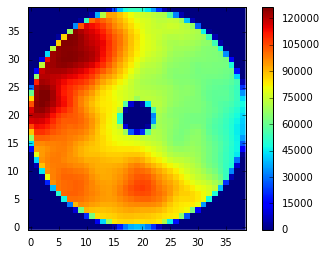

In [3]:
cube = SpectralCube.read(
    "../nro_maps/12CO_20161002_FOREST-BEARS_spheroidal_xyb_grid7.5_0.099kms.fits").subcube(
        ra + r_angle + dr_angle / 2.,
        ra - r_angle - dr_angle / 2.,
        dec - r_angle - dr_angle / 2.,
        dec + r_angle + dr_angle / 2.,
        v0 - vexp,
        v0 + vexp
        )
#print(cube)
mom0 = cube.moment0()

inner = CircleSkyRegion(
    center=shell_center,
    radius=r_angle - dr_angle / 2.
    ).to_pixel(mom0.wcs).to_mask(mode='exact').to_image(mom0.shape)

outer = CircleSkyRegion(
    center=shell_center,
    radius=r_angle + dr_angle / 2.,
    ).to_pixel(cube.wcs).to_mask(mode='exact').to_image(mom0.shape)
annulus = outer - inner
plt.imshow(annulus*mom0.data, interpolation='none')
plt.colorbar()
print(np.sum(annulus*mom0.data)*u.K*u.km/u.s)
shell_voxels = np.array([annulus*cube[i,:,:].data for i in range(cube.shape[0])])
shell_voxels.shape


In [87]:
def extract_shell(cube=None, ra=None, dec=None,
    r=None, dr=None, vexp=None, v0=None, mask_mode='exact', dist=414*u.pc,
    subtract_inner=True):
    
    r_angle = (r / dist) * u.radian
    dr_angle = (dr / dist) * u.radian
    
    cube = SpectralCube.read(cube).subcube(
        ra + r_angle + dr_angle / 2.,
        ra - r_angle - dr_angle / 2.,
        dec - r_angle - dr_angle / 2.,
        dec + r_angle + dr_angle / 2.,
        v0 - vexp,
        v0 + vexp
        )
    
    #mom0 = cube.moment0()
    
    center = SkyCoord(ra, dec)
    r_angle = u.rad * r / dist
    dr_angle = u.rad * dr / dist
    
    mask_inner = CircleSkyRegion(
        center=center,
        radius=r_angle - dr_angle / 2.
    ).to_pixel(cube.wcs).to_mask(mode=mask_mode).to_image(mom0.shape)
    mask_outer = CircleSkyRegion(
        center=center,
        radius=r_angle + dr_angle / 2.
    ).to_pixel(cube.wcs).to_mask(mode=mask_mode).to_image(mom0.shape)
    
    mask_annulus = mask_outer - mask_inner
        
    shell_voxels = np.array([mask_annulus*cube[i,:,:].data for i in range(cube.shape[0])])
    

    